# Building Simple Text Preprocessing Pipeline: UN General Debates

Tutorial on how to do a simple text preprocessing on a corpus of document that we have. Functions referred to Blueprints for Text Analytics by Albrecht et al. (2021) with several adjustments to make it more clear. For the ready-to-use functions, please refer to file **fun_preprocessin_text.py.**

In [26]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re  # regular expression
import nltk  # library that contains stopwords, especially in english
import itertools  # to iterate items in set
from textacy.extract.kwic import keyword_in_context as KWIC  # to make keyword-in-context (KWIC) analysis
from wordcloud import WordCloud  # to make word clouds

from collections import Counter  # to count list contains, similar to value_counts(), but faster

In [27]:
df_text = pd.read_csv('dataset/un-general-debates.csv')
display(df_text.sample(5))
print('length of dataframe:', len(df_text))

,session,year,country,text
7067,61,2006,BLR,It is \ngenerally considered that the struggle...
1572,67,2012,THA,﻿On behalf of the\ndelegation of the Kingdom o...
507,40,1985,PNG,My delegation and I would like to congratulate...
1462,51,1996,LKA,﻿For Sri Lanka it is a\nmatter of particular p...
3556,54,1999,BFA,"Your brilliant election, Mr. President, to the..."


length of dataframe: 7507


In [28]:
df_speakers = pd.read_excel('dataset/Speakers_by_session.xlsx')
display(df_speakers.sample(5))
print('length of dataframe:', len(df_speakers))

,Year,Session,ISO Code,Country,Name of Person Speaking,Post,Language,Notes
3259,2003,58,TUV,Tuvalu,Saufatu Sopoanga,Prime Minister,NaN,NaN
7421,1977,32,NIC,Nicaragua,MONTIEL ARGUELLO,NaN,Spanish,NaN
4469,1996,51,LUX,Luxembourg,Jacques Poos,Deputy Prime Minister,French,NaN
5598,1989,44,EGY,Egypt,Mohamed Hosni Mubarak,President,Arabic,NaN
5975,1987,42,PRT,Portugal,PINHEIRO,NaN,Portuguese,Spoke in Portuguese; English text furnished by...


length of dataframe: 8294


## Data Preparation

    Still need to join and merge between main df and df_speakers

In [29]:
df = df_text.merge(df_speakers,
                   left_on=['year', 'session', 'country'], 
                   right_on=['Year', 'Session', 'ISO Code'], 
                   how='inner')
df = df[['session', 'year', 'country', 'Country', 'Name of Person Speaking', 'Post', 'Language', 'text']]

display(df.sample(5))
print('length of dataframe:', len(df))

,session,year,country,Country,Name of Person Speaking,Post,Language,text
3846,42,1987,IDN,Indonesia,Kusumaatmadja,NaN,NaN,"﻿Allow me first, on behalf of the Indonesian d..."
5980,36,1981,TZA,Tanzania,Mr. SALIM,NaN,NaN,72.\tLet me at the outset sincerely congratula...
6502,28,1973,TUN,Tunisia,Masmoudi,NaN,French,"﻿120.\t Mr. President, the Tunisian delegation..."
5325,29,1974,LBN,Lebanon,Mr. Naffah,NaN,Arabic,"Mr. President, I am particularly pleased to ex..."
2362,65,2010,LBR,Liberia,Ellen Johnson-Sirleaf,President,NaN,I am honoured to \naddress this sixty-fifth se...


length of dataframe: 7475


In [30]:
# renaming columns to make it analyzable

df.rename(columns={'Country': 'country_name', 'Name of Person Speaking': 'speaker', 'Post': 'position', 'Language': 'lang'}, 
          inplace=True)
df.sample(5)

,session,year,country,country_name,speaker,position,lang,text
6447,45,1990,DEU,Germany,BRAUTIGAM,NaN,NaN,"﻿I wish first of all to offer you, Mr. Preside..."
3881,42,1987,MAR,Morocco,FILALI,NaN,French,﻿\nOn behalf of the delegation of the Kingdom ...
5494,70,2015,NZL,New Zealand,Mr. John Key,Prime minister,English,The seventieth anniversary of the United Natio...
3753,60,2005,SOM,Somalia,Abdullahi Yusuf Ahmed,President,NaN,On behalf of the Republic of\nSomalia I am ver...
7465,56,2001,MOZ,Mozambique,Leonardo Santos Simão,Minister for Foreign Affairs,NaN,﻿I wish to congratulate\nHis Excellency Mr. Ha...


## Overview of the Data

    Calculate summary statistics (columns, dtypes, info, and descripe)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7475 entries, 0 to 7474
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7475 non-null   int64 
 1   year          7475 non-null   int64 
 2   country       7475 non-null   object
 3   country_name  7475 non-null   object
 4   speaker       7473 non-null   object
 5   position      4493 non-null   object
 6   lang          4038 non-null   object
 7   text          7475 non-null   object
dtypes: int64(2), object(6)
memory usage: 525.6+ KB


In [32]:
# in text analytics, it is IMPORTANT to know the length of the text
# thus, using str.len(), we will try to analyze the length of the text

df['text_length'] = df['text'].str.len()

In [33]:
# summary for NUMERICAL data
# using describe method

df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7475.0,49.599866,12.888679,25.0,39.0,51.0,61.0,70.0
year,7475.0,1994.599866,12.888679,1970.0,1984.0,1996.0,2006.0,2015.0
text_length,7475.0,17959.037057,7857.306625,2362.0,12067.5,16420.0,22467.5,72041.0


In [34]:
# summary for CATEGORICAL data
# using describe method, but pass the parameter (include='O')

df.describe(include='O').T

,count,unique,top,freq
country,7475,199,SLV,47
country_name,7475,412,Pakistan,46
speaker,7473,5425,Seyoum Mesfin,12
position,4493,113,Minister for Foreign Affairs,1813
lang,4038,113,French,909
text,7475,7474,It\nis my great honour to represent the Salvad...,2


    Checking for the Data One-by-One

In [35]:
# checking total of nan values in the columns
# we're going to replace all the data with "unknown"

df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker            2
position        2982
lang            3437
text               0
text_length        0
dtype: int64

In [36]:
# filling nan with "unknown"

df.fillna('unknown', inplace=True)
df.isna().sum()

session         0
year            0
country         0
country_name    0
speaker         0
position        0
lang            0
text            0
text_length     0
dtype: int64

In [37]:
# the naming convention is inconsistent
# even the position itself

df[df.country == 'USA'].sample(10)

,session,year,country,country_name,speaker,position,lang,text,text_length
6121,55,2000,USA,USA,Madeleine Korbel Albright,Minister for Foreign Affairs,unknown,I am\nhonoured to address the Assembly on beha...,14782
2564,50,1995,USA,United States,Mr. Christopher,Minister for Foreign Affairs,unknown,It is\na privilege to speak to the General Ass...,20859
5246,29,1974,USA,United States of America,Mr. Kissinger,unknown,unknown,"Last year, at the previous session [.2124th me...",26413
3281,38,1983,USA,United States Minor Outlying Islands,Reagan,President,unknown,﻿1.\tThank you for granting me the honor of sp...,19456
1757,52,1997,USA,USA,Bill Clinton,President,unknown,"﻿Five years ago, when I first\naddressed this ...",18008
1422,51,1996,USA,USA,William Jefferson Clinton,President,unknown,﻿Three years ago I had the honour\nof being th...,15995
2029,33,1978,USA,USA,Vance,unknown,Spanish,"﻿103.\tMr. President, I congratulate you on yo...",35732
6449,45,1990,USA,USA,GEORGE BUSH,unknown,unknown,﻿\nIt is really a great privilege to greet you...,15843
7077,61,2006,USA,The United States of America,Mr. George W. Bush,President,unknown,I am grateful for the privilege of \nspeaking ...,16675
3125,31,1976,USA,United States of America,Mr. Kissinger,unknown,unknown,Let me first congratulate this body for electi...,43287


In [38]:
# check how many Bush we have
# as str.contains accepts a regular expression pattern
# thus we can join list of 'Bush' and 'BUSH' with regex

list = ['Bush', 'BUSH']
pattern = '|'.join(list)

df[df['speaker'].str.contains(pattern)]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Mr. George BUSH       1
GEORGE BUSH           1
Name: speaker, dtype: int64

## Exploratory Data Analysis (EDA)

    Plot for Speech Length  

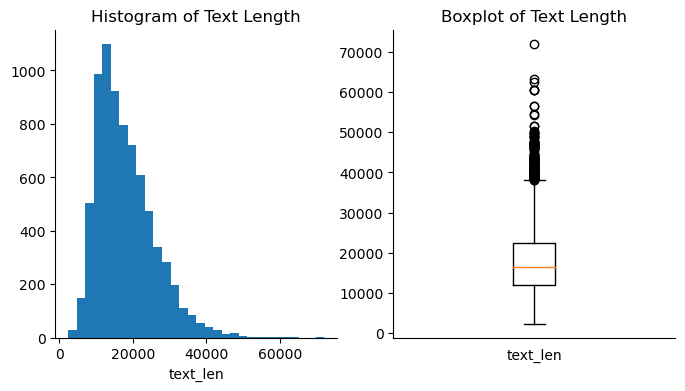

In [39]:
# plot using histogram and boxplot
# boxplot shows minimum, 1st quartile, median, 3rd quartile, and maximum

plt.figure(figsize=(8,4))

ax1 = plt.subplot(121)
plt.hist(df['text_length'], bins=30)
plt.title('Histogram of Text Length')
plt.xlabel('text_len')

ax2 = plt.subplot(122)
plt.boxplot(df['text_length'])
plt.title('Boxplot of Text Length')
plt.xticks([], [])
plt.xlabel('text_len')

sns.despine()
plt.show()

    Top Appearences of Countries

In [40]:
# maximum appearence is 46 times
# filter by 46 times

df.country_name.value_counts().loc[lambda x : x == 46]

Pakistan     46
Japan        46
Belgium      46
Colombia     46
India        46
Ecuador      46
Turkey       46
Albania      46
Ghana        46
Indonesia    46
Sudan        46
France       46
Iceland      46
Uruguay      46
Algeria      46
Name: country_name, dtype: int64

    Comparing 5 Permanent UN Security Council: USA, France, United Kingdom, China, and Russia

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try violinplot
  warnings.warn(msg, UserWarning)


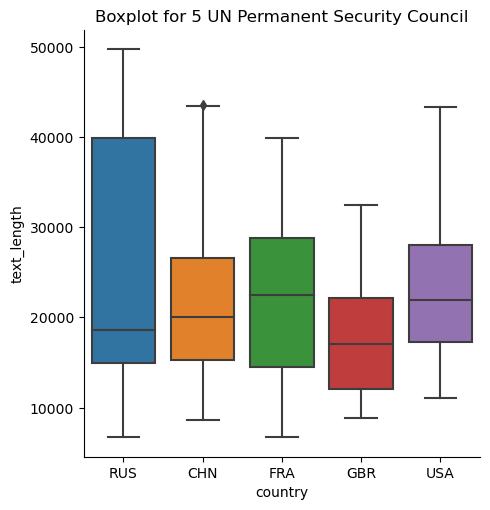

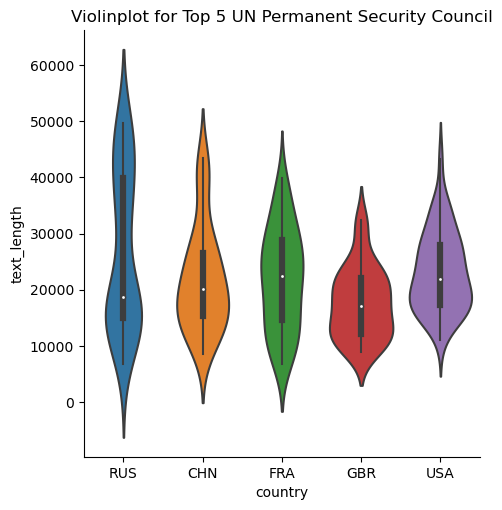

In [41]:
temp_df = df[df['country'].isin(['FRA', 'GBR', 'USA', 'CHN', 'RUS'])]


g = sns.catplot(data=temp_df, x='country', y='text_length', kind='box', ax=ax1)
g.set(title = 'Boxplot for 5 UN Permanent Security Council')

g = sns.catplot(data=temp_df, x='country', y='text_length', kind='violin', ax=ax2)
g.set(title = 'Violinplot for Top 5 UN Permanent Security Council')

    Visualizing Development of Number of Countries and Their Avg. Speech Length Over Time

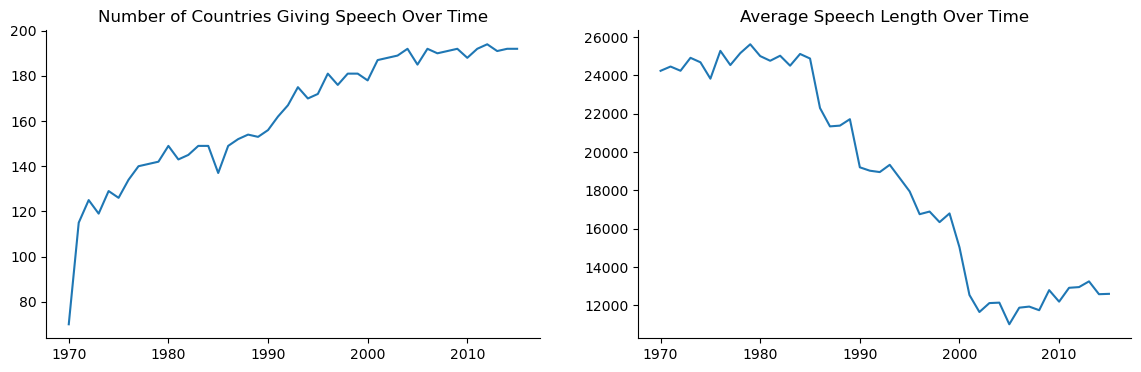

In [42]:
plt.figure(figsize=(14,4))

ax1 = plt.subplot(121)
plt.plot(df.groupby('year').agg({'country': 'count'}))
plt.title('Number of Countries Giving Speech Over Time')

ax2 = plt.subplot(122)
plt.plot(df.groupby('year').agg({'text_length': 'mean'}))
plt.title('Average Speech Length Over Time')

sns.despine()

# Building Simple Preprocessing Pipeline

In a simple text preprocessing pipeline, there are at least 3 steps before our source text becoming a prepared tokens that can be analyzed using any algorithms we want to use.
- Case-folding (transforming lettercase into lowercase)
- Tokenization
- Stop word removal

    Performing Tokenization with RegEx

In [43]:
# create a function to tokenize sentence
# []        : denote a character class. A character class will match any of the things inside it.
# \         : quotes the character after it, both special and ordinary.
# \w        : a special class called "word characters". It is shorthand for [a-zA-Z0-9_]
# *         : the asterisk represents anywhere from zero to an infinite amount of characters.
# \p{L}     : matches a single code point in the category "letter"

import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [44]:
# test the tokenize function

text = "In March this year, I will get a job and will be back to Indonesia"
tokens = tokenize(text)
print('|'.join(tokens))

In|March|this|year|I|will|get|a|job|and|will|be|back|to|Indonesia


    Treating Stop Words

In [45]:
import nltk  # change nltk with any libraries later if we want to use stopwords listed from any other libraries

stopwords = set(nltk.corpus.stopwords.words('english'))  # this is the important point

print('number of stopwords:', len(stopwords))
print(set(itertools.islice(stopwords, 5)))

number of stopwords: 179
{'which', 'shan', 'how', 'weren', 'once'}


In [46]:
# function to remove stop words

def remove_stop(tokens, stopwords):
    return [t for t in tokens if t.lower() not in stopwords]

    Compiling into One Line of Code

In [47]:
# the long version to make the pipeline function
# we already have tokenize() and remove_stop()

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [48]:
# apply pipeline to every text in the dataframe
# using Series.apply method, to take other function's parameter as its parameter and apply it into every element

df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)
df.sample(5)

,session,year,country,country_name,speaker,position,lang,text,text_length,tokens
5984,36,1981,MYS,Malaysia,Mr. Muhammad GHAZALI,unknown,unknown,\n195.\tI am indeed gratified to see an illust...,20777,"[indeed, gratified, see, illustrious, son, ira..."
634,63,2008,GRC,Greece,Dora Bakoyannis,Minister for Foreign Affairs,NO,Sophocles said that all mankind is subject to ...,12824,"[sophocles, said, mankind, subject, error, gat..."
4274,53,1998,MLT,Malta,Guido de Marco,Deputy Prime Minister,unknown,I join other delegations in\ncongratulating yo...,26905,"[join, delegations, congratulating, sir, elect..."
1284,30,1975,BRA,Brazil,Mr. AZEREDO DA SILVEIRA,unknown,unknown,"Mr. President, may my first words express the...",15842,"[mr, president, may, first, words, express, sa..."
4581,59,2004,DNK,Denmark,Dr. Per Stig Møller,Minister for Foreign Affairs,unknown,"When we met a year\nago, there was widespread ...",10577,"[met, year, ago, widespread, concern, reached,..."


# Data Analysis: Word Frequency Analysis

    Basic Foundation of Word Frequency Analysis

In [49]:
# count how many times the words appear

counter = Counter()

df['tokens'].map(counter.update)
display(counter.most_common(10))  # show top 10 most occurence

# uncomment below if you want to restart counter
# counter.clear()

[('nations', 123975),
 ('united', 120211),
 ('international', 116668),
 ('world', 89030),
 ('countries', 85312),
 ('peace', 72288),
 ('development', 62338),
 ('states', 59404),
 ('people', 59065),
 ('security', 58117)]

    Make a Function to Make a DataFrame from Word Counter

In [50]:
'''
count_words() is a function to count how many words appear in the text
df          : the data frame
columns     : column that contains token (should be tokenized first into list)
preprocess  : process token and update counter
min_freq    : min_frequency for a word in the text
'''


def count_words(df, column, preprocess=None, min_freq=2):
    
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    
    counter = Counter()
    df[column].map(counter.update)
    
    df_freq = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    df_freq = df_freq[df_freq['freq'] > min_freq]
    df_freq.index.name = 'token'
    
    return df_freq.sort_values('freq', ascending=False)

In [51]:
df_freq = count_words(df, 'tokens')
df_freq.head(5)

,freq
token,
nations,123975
united,120211
international,116668
world,89030
countries,85312


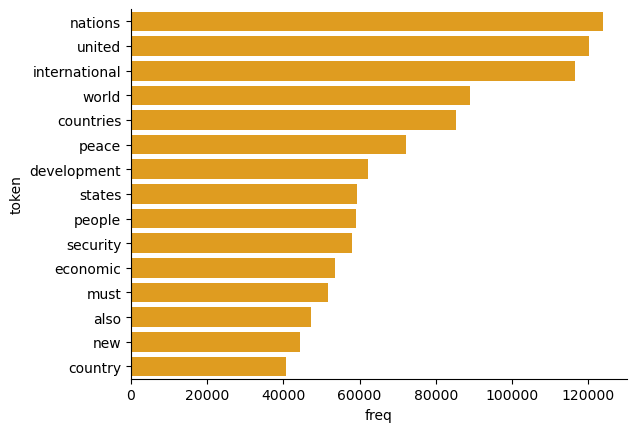

In [52]:
# plot the occurence of top 15 words in a horizontal bar plot

sns.barplot(x='freq', y='token', 
            data=df_freq.reset_index().head(15), 
            color='orange')
sns.despine()

plt.show()

(-0.5, 399.5, 199.5, -0.5)

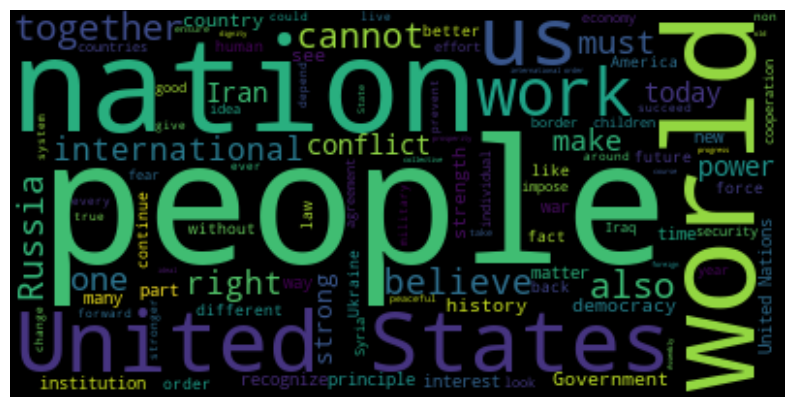

In [53]:
# make a wordcloud
# let's test it in a text from our data that we have
# can only be applied for a single text, not for a big corpsu

text = df[(df['year'] == 2015) & (df['country'] == 'USA')]['text'].values[0]

wc = WordCloud(max_words=100, stopwords=stopwords)  # generate wordcloud method
wc.generate(text)  # generate the wordcloud

# plot it using matplotlib
# the argument 'interpolation=bilinear' is used to make the image appear smoother.

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')  
plt.axis('off')

In [54]:
type(df_freq['freq'])

pandas.core.series.Series

In [55]:
df_freq['freq'].to_dict()

{'nations': 123975,
 'united': 120211,
 'international': 116668,
 'world': 89030,
 'countries': 85312,
 'peace': 72288,
 'development': 62338,
 'states': 59404,
 'people': 59065,
 'security': 58117,
 'economic': 53604,
 'must': 51659,
 'also': 47183,
 'new': 44255,
 'country': 40696,
 'assembly': 40244,
 'community': 38129,
 'government': 37318,
 'general': 36976,
 'organization': 36288,
 'human': 36228,
 'would': 35739,
 'efforts': 35049,
 'us': 34469,
 'rights': 33356,
 'political': 33215,
 'one': 31689,
 'africa': 31160,
 'support': 30103,
 'council': 29431,
 'session': 29291,
 'developing': 25886,
 'peoples': 25011,
 'time': 24733,
 'order': 23473,
 'republic': 23217,
 'national': 23103,
 'problems': 23076,
 'many': 22723,
 'year': 22616,
 'situation': 22538,
 'state': 22455,
 'years': 22293,
 'south': 22150,
 'global': 21775,
 'conference': 21652,
 'region': 21342,
 'social': 21048,
 'like': 20497,
 'work': 20427,
 'made': 20245,
 'war': 19975,
 'great': 19409,
 'process': 19406,


In [56]:
df

,session,year,country,country_name,speaker,position,lang,text,text_length,tokens
0,44,1989,MDV,Maldives,JAMEEL,unknown,unknown,﻿It is indeed a pleasure for me and the member...,19023,"[indeed, pleasure, members, delegation, extend..."
1,44,1989,FIN,Finland,Paasio,unknown,unknown,"﻿\nMay I begin by congratulating you. Sir, on ...",17396,"[may, begin, congratulating, sir, election, pr..."
2,44,1989,NER,Niger,SANI BAKO,unknown,French,"﻿\nMr. President, it is a particular pleasure ...",30780,"[mr, president, particular, pleasure, behalf, ..."
3,44,1989,URY,Uruguay,BARRIOS TASSANO,unknown,Spanish,﻿\nDuring the debate at the fortieth session o...,17249,"[debate, fortieth, session, general, assembly,..."
4,44,1989,ZWE,Zimbabwe,Shamuyarira,unknown,unknown,﻿I should like at the outset to express my del...,27779,"[like, outset, express, delegation, satisfacti..."
...,...,...,...,...,...,...,...,...,...,...
7470,56,2001,KAZ,Kazakhstan,Madina Jarbussynova,UN Representative,unknown,﻿This session\nthat is taking place under extr...,9510,"[session, taking, place, extraordinary, circum..."
7471,56,2001,LBR,Liberia,Monie Captan,Minister for Foreign Affairs,unknown,﻿I am honoured to\nparticipate in this histori...,15573,"[honoured, participate, historic, session, beh..."
7472,56,2001,BDI,Burundi,Thérence Sinunguruza,Minister for Foreign Affairs,French,﻿It\nis for me a signal honour to take the flo...,16767,"[signal, honour, take, floor, today, assembly,..."
7473,56,2001,HUN,Hungary,János Martonyi,Minister for Foreign Affairs,French,"﻿First, may I congratulate Mr. Han Seung-soo o...",11593,"[first, may, congratulate, mr, han, seung-soo,..."


In [57]:
df_freq['freq'].to_dict()

{'nations': 123975,
 'united': 120211,
 'international': 116668,
 'world': 89030,
 'countries': 85312,
 'peace': 72288,
 'development': 62338,
 'states': 59404,
 'people': 59065,
 'security': 58117,
 'economic': 53604,
 'must': 51659,
 'also': 47183,
 'new': 44255,
 'country': 40696,
 'assembly': 40244,
 'community': 38129,
 'government': 37318,
 'general': 36976,
 'organization': 36288,
 'human': 36228,
 'would': 35739,
 'efforts': 35049,
 'us': 34469,
 'rights': 33356,
 'political': 33215,
 'one': 31689,
 'africa': 31160,
 'support': 30103,
 'council': 29431,
 'session': 29291,
 'developing': 25886,
 'peoples': 25011,
 'time': 24733,
 'order': 23473,
 'republic': 23217,
 'national': 23103,
 'problems': 23076,
 'many': 22723,
 'year': 22616,
 'situation': 22538,
 'state': 22455,
 'years': 22293,
 'south': 22150,
 'global': 21775,
 'conference': 21652,
 'region': 21342,
 'social': 21048,
 'like': 20497,
 'work': 20427,
 'made': 20245,
 'war': 19975,
 'great': 19409,
 'process': 19406,


In [58]:
'''
wordcloud_freq() is a function to make a wordcloud based on the frequency dataframe
word_freq   : a series that contains the token and its frequency, should be a series
title       : the title of wordcloud that you want to set up
max_words   : how many words in maximum you want to plot
stopwords   : set that contain stop words
'''

def wordcloud_freq(word_freq, title, max_words=200, stopwords=None):
    
    # define the wc method first
    wc = WordCloud(width=800, height=400,
                   background_color='black', colormap='Paired',
                   max_font_size=150, max_words=max_words)
    
    # convert dataframe into dictionairy
    counter = word_freq.fillna(0).to_dict()
    
    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                   if token not in stopwords}
        
    wc.generate_from_frequencies(counter)  # generate wc from a dictionary that contain frequency that words appear
    
    plt.title(title)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')

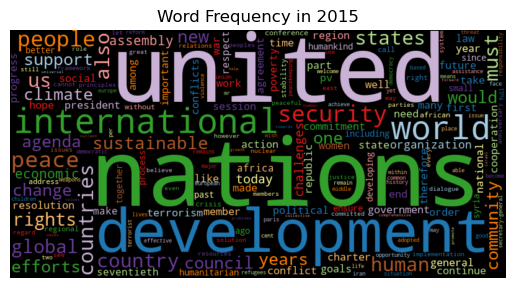

In [59]:
# let's test our function by comparing the appearence of words between 1970 and 2015
# call the count_words first
# after that, we can input our data frame to worldcloud_freq function

df_freq_1970 = count_words(df[df['year'] == 1970], 'tokens')
df_freq_2015 = count_words(df[df['year'] == 2015], 'tokens')

wordcloud_freq(df_freq_1970['freq'], title='Word Frequency in 1970')
wordcloud_freq(df_freq_2015['freq'], title='Word Frequency in 2015')

    Word Counter with Term Frequency-Inverse Document Frequency (TF-IDF)

The inverse document frequency (IDF) is a weighting factor that measures the “unusu‐ alness” of a term in a corpus. It is often used to reduce the influence of common terms for data analysis or machine learning. To summarize the key intuition motivating TF-IDF is the importance of a term is inversely related to its frequency across documents. **TF** gives us information on how often a term appears in a document and **IDF** gives us information about the relative rarity of a term in the collection of documents.

In [60]:
# the function is pretty similar to count_words, but the different is it calculates the inverse of the frequency
# and each token is counted only once per document, thus even though the 'clear' mentioned 10 times in a speech, it's still counted as

'''
compute_idf() is a function to count how many words appear in the text, then inversed (tf-idf)
df          : the data frame
columns     : column that contains token (should be tokenized first into list)
preprocess  : process token and update counter
min_freq    : min_frequency for a word in the text
'''


def compute_idf(df, column, preprocess=None, min_freq=2):
    
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))  # each token is counted only once per document
    
    counter = Counter()
    df[column].map(update)
    
    df_idf = pd.DataFrame.from_dict(counter, orient='index', columns=['doc_freq'])  # caculate the frequency of word in every document first
    df_idf = df_idf[df_idf['doc_freq'] > min_freq]
    df_idf['idf'] = np.log(len(df)/(df_idf['doc_freq']+1))  # calculate idf, the inverse of document frequency
    df_idf.index.name = 'token'

    return df_idf.sort_values('doc_freq', ascending=False)

In [61]:
# this is only to compute idf (only the weight)
# to compute tf-idf, we have to multiply tf and idf
# IMPORTANT! we have to define idf relative to the corpus first before we subset

df_idf = compute_idf(df, 'tokens')
df_idf['tfidf'] = df_idf['doc_freq'] * df_idf['idf']

df_idf

,doc_freq,idf,tfidf
token,,,
nations,7463,0.001473,10.990430
united,7462,0.001607,11.988756
international,7434,0.005366,39.887420
world,7428,0.006173,45.851997
also,7380,0.012655,93.393815
...,...,...,...
mystic,3,7.533025,22.599075
recoils,3,7.533025,22.599075
ottowa,3,7.533025,22.599075


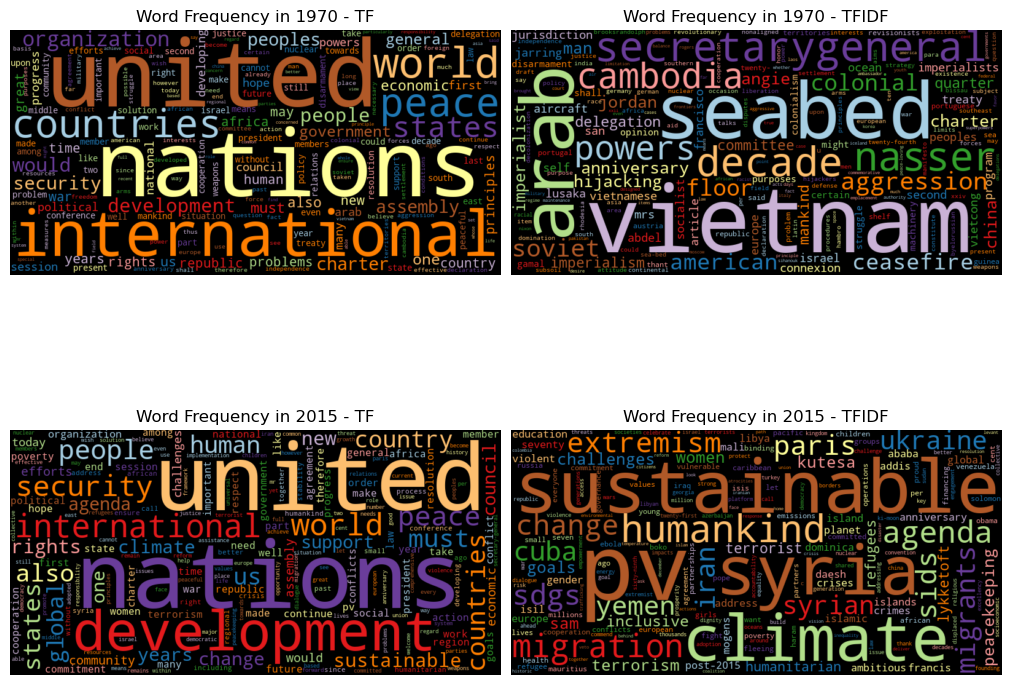

In [62]:
# comparing between wordcloud for tf and tf-idf

# let's test our function by comparing the appearence of words between 1970 and 2015
# call the count_words first
# after that, we can input our data frame to worldcloud_freq function

df_freq_1970 = count_words(df[df['year'] == 1970], 'tokens')
df_freq_2015 = count_words(df[df['year'] == 2015], 'tokens')

df_freq_1970['tfidf'] = df_freq_1970['freq'] * df_idf['idf']  # we should slice after we compute the total idf to the corpus
df_freq_2015['tfidf'] = df_freq_2015['freq'] * df_idf['idf']  # this one as well

df_idf['tfidf'] = df_idf['doc_freq'] * df_idf['idf']

plt.figure(figsize=(10,8), layout='constrained')

ax1 = plt.subplot(221)
wordcloud_freq(df_freq_1970['freq'], title='Word Frequency in 1970 - TF', 
               stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])

ax2 = plt.subplot(222)
wordcloud_freq(df_freq_1970['tfidf'], title='Word Frequency in 1970 - TFIDF',
               stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])

ax3 = plt.subplot(223)
wordcloud_freq(df_freq_2015['freq'], title='Word Frequency in 2015 - TF',
               stopwords=['seventieth'])

ax4 = plt.subplot(224)
wordcloud_freq(df_freq_2015['tfidf'], title='Word Frequency in 2015 - TFIDF',
               stopwords=['seventieth'])

plt.show()

    Finding A Keyword in Context (KWIC) Analysis

Producing a list of text fragments of equal length showing the left and right context of a keyword.

In [145]:
'''
kwic() is a function to do the keyword-in-context (KWIC) analysis
doc_series      : the series containing the text
keyword         : word that we want to analyze, as the keyword
windows         : how many words to the left and to the right
print_samples   : how many samples do you want to see
'''


def kwic(doc_series, keyword, window=35, print_samples=5):
    
    # make the list of kwic 
    # using the KWIC function from textacy library
    
    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True,
                              window_width=window))
    kwic_list = []
    doc_series.map(add_kwic)
    
    if print_samples is None or print_samples == 0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        
        print(f'{k} random samples out of {len(kwic_list)} contexts {keyword}:')
        
        # to print kwic list
        # re.sub is used to replace \n string to space as there's a lot of \n in the text
        # IMPORTANT! Change this one based on needs
        
        i = 1
        for sample in random.sample(kwic_list, k):
            print(str(i) + ') ' + (re.sub(r'[\n\t]', ' ', sample[0])) + ' ' + \
                sample[1] + ' ' + \
                    (re.sub(r'[\n\t]', ' ', sample[2])))
            i += 1

In [151]:
# example here, we want to analyze what does pv mean in the text from df 2015
# pv is only a citation, thus we can remove it by setting in the wordcloud as a stopword

kwic(df[df['year'] == 2015]['text'], keyword='pv')

5 random samples out of 463 contexts pv:
1) but to give them a life” (see A/70/ PV .13) — a dignified, full life with 
2) ical parties 15-29816 43/45  A/70/ PV .25 02/10/2015 responded positively
3) , oil heists 15-29816 41/45  A/70/ PV .25 02/10/2015 and other transnatio
4) ds 6/51 15-29431  29/09/2015 A/70/ PV .16 to build a new type of internat
5) he international community.” (A/70/ PV .3, p. 5) The current crisis calls 


In [152]:
# another example here, we want to analyze what does sids mean in the text from df 2015

kwic(df[df['year'] == 2015]['text'], keyword='sids')

5 random samples out of 84 contexts sids:
1)  is needed in order to ensure that  SIDS  security issues are meaningfully a
2) he solutions to the afflictions of  SIDS  will automatically follow. As a re
3) st small island developing States ( SIDS ), Tuvalu is fully aware of its res
4) is of particular importance to all  SIDS  and coastal States. It presents us
5) tes Sustainable Energy Initiative ( SIDS  DOCK). The statute came into force


    N-Grams Analysis: Frequency Analysis From Single Words to Short Sequences

Basically, we are looking for two types of word sequences: compounds and collocations. 
- **Compound** is a combination of two or more words with a specific meaning, e.g: earthquake, self-confident
- **Collocations**, in contrast, are words that are frequently used together, e.g: red carpet, united nations

In text processing, we usually work with bigrams (sequences of length 2), sometimes even trigrams (length 3). n-grams of size 1 are single words, also called unigrams.

In [154]:
'''
ngrams() frequency analysis for phrases (combination between 2 or 3 words)
tokens      : a list of words that has been tokenized
n           : number of n grams (2 or 3, set default at 2)
sep         : set the separator between words
stopwords   : set the stopwords
'''

def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords]) == 0]
    
# ngrams on all tokens but keep only those that do not contain any stop words 
# thus why we set stopwords there

In [157]:
# let's try the function on a text I wrote by myself

text = 'united nations will take an action based on the incident that happened 3 days ago.'
tokens = tokenize(text)

print('Bigrams:', "|".join(ngrams(tokens, stopwords=stopwords)))
print('Bigrams:', "|".join(ngrams(tokens, n=3, stopwords=stopwords)))

Bigrams: united nations|action based|happened days|days ago
Bigrams: happened days ago


In [160]:
# let's try with our data set
# do not remove stopwords when preprocessing!

df['bigrams'] = df['text'].apply(prepare, pipeline=[str.lower, tokenize]) \
    .apply(ngrams, n=2, stopwords=stopwords)
    
# then count the bigrams

count_words(df, 'bigrams')

,freq
token,
united nations,102766
international community,27666
general assembly,26983
security council,20849
human rights,19772
...,...
many reasonable,3
strategically europe,3
facade behind,3


In [164]:
count_words(df, 'bigrams').index

Index(['united nations', 'international community', 'general assembly',
       'security council', 'human rights', 'developing countries',
       'united states', 'middle east', 'south africa', 'member states',
       ...
       'community developed', 'conducted consultations', 'white rule',
       'combat imperialism', 'safeguard state', 'many reasonable',
       'strategically europe', 'facade behind', 'sheer deception',
       'arusha accords'],
      dtype='object', name='token', length=191437)

In [181]:
temp_df[temp_df.index.str.contains('climate')]

,freq
token,
climate change,5157
international climate,353
political climate,318
global climate,140
new climate,122
...,...
genuine climate,3
true climate,3
survival climate,3


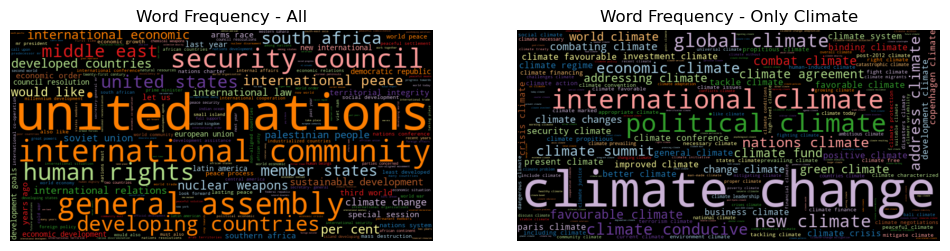

In [185]:
# comparing the wordcloud with all data
# and the data that only contains 'climate' in the phrase

temp_df = count_words(df, 'bigrams')

plt.figure(figsize=(12,6))

ax1 = plt.subplot(121)
wordcloud_freq(temp_df['freq'], title='Word Frequency - All')

ax2 = plt.subplot(122)
wordcloud_freq(temp_df[temp_df.index.str.contains('climate')]['freq'], title='Word Frequency - Only Climate')

plt.show()

    Frequencies Across Time Intervals and Categories

In [189]:
# create individual counter between lists

'''
count_keywords_list() frequency analysis for phrases (combination between 2 or 3 words)
tokens      : a list of words from a document that has been tokenized
keywords    : list of keywords we want to count
'''

def count_keywords_list(tokens, keywords):
    
    tokens = [t for t in tokens if t in keywords]  # only calculate the appearence of token listed in keywords
    counter = Counter(tokens)  # count the appearence of the token in the keyword
    
    return [counter.get(k, 0) for k in keywords]  

In [190]:
# test the individual counter between lists

keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

count_keywords_list(tokens, keywords)

[1, 0, 3, 2]

In [197]:
# make the counter from a corpus

'''
count_keywords_corpus() frequency analysis for phrases (combination between 2 or 3 words)
df          : the main dataframe of the corpus
by          : grouping by which column
keywords    : list of words that we want to check
column      : column that contain the tokens
'''

def count_keywords_corpus(df, by, keywords, column='tokens'):
    
    freq_matrix = df[column].apply(count_keywords_list, keywords=keywords)  # utilize count_keywords_list
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]  # copy the column
    
    return freq_df.groupby(by).sum().sort_values(by)

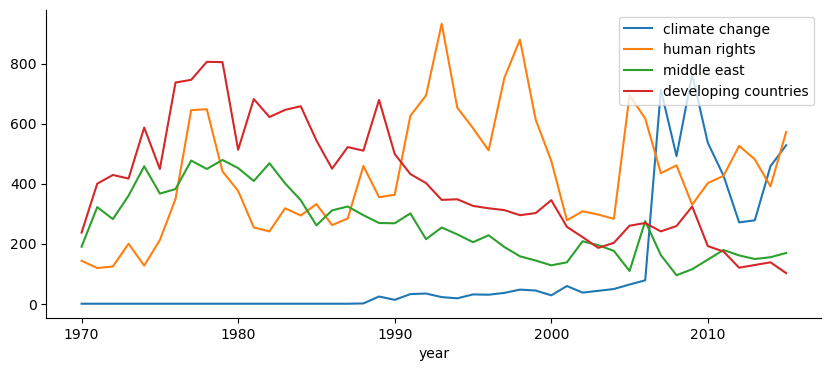

In [211]:
# let's try the function using our current dataframe
# if we want to calculate bigrams, we can set the paramaeter for column to 'bigrams' instead of 'tokens'

keywords = ['climate change', 'human rights', 'middle east', 'developing countries']

count_keywords_corpus(df, 'year', keywords, column='bigrams').plot(figsize=(10,4))
sns.despine()

    Frequencies, But Using Heatmap

<AxesSubplot:xlabel='year'>

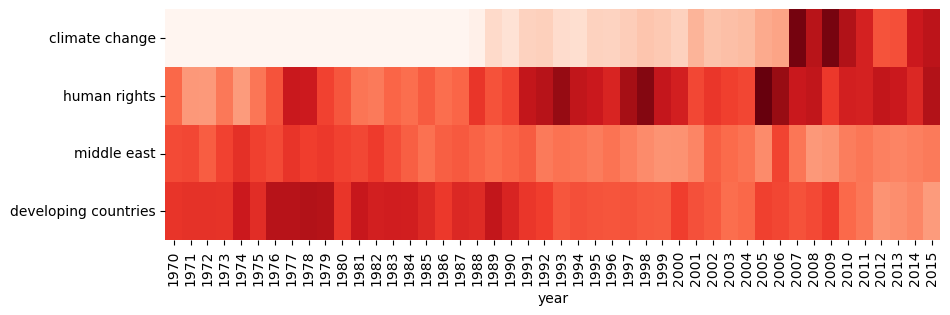

In [251]:
temp_df = count_keywords_corpus(df, 'year', keywords, column='bigrams')
df['num_of_tokens'] = df['tokens'].map(len)
temp_df = temp_df.div(df.groupby('year')['num_of_tokens'].sum(), axis=0)  # dividing by number of tokens in every year
temp_df = temp_df.apply(np.sqrt)

plt.figure(figsize=(10,3))
sns.heatmap(data=temp_df.T, cbar=False, cmap='Reds')